In [38]:
import sys
import os


sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("NonHermitianQW"))))

In [39]:
from operators import op
from oneDimQW import *
from twoDimQW import *
import numpy as np
from matplotlib import pyplot as plt
from numpy import pi
from numpy.linalg import eig
from scipy.linalg import expm
from berry import BerryPhase
from sympy import *
from ploting import berry_bloch_phase

In [40]:
import ipywidgets as widgets
from ipywidgets import interact

<h1>Single coin, two dimensional Quantum Walk</h1>

Hilbert space is composed of three parts:
$$
\mathcal{H} = \mathcal{H}_{x} \otimes \mathcal{H}_{y} \otimes \mathcal{H}_{C}
$$
Evolution operator can be written as:
$$
U = S_{x} C(\theta_{x}) S_{y} C(\theta_{y})
$$
where:
$$
S_{x} = \sum_{x,y = 0}^{d-1}(|x+1,y\rangle\langle x,y|\otimes |+\rangle\langle +|+|x-1,y\rangle\langle x,y|\otimes |-\rangle\langle -|) =
$$
$$
=\sum_{k_{x},k_{y}\in BZ} (e^{-ik_{x}}|k_{x},k_{y}\rangle\langle k_{x},k_{y}| \otimes |+\rangle\langle + | +
e^{ik_{x}}|k_{x},k_{y}\rangle\langle k_{x},k_{y}| \otimes |-\rangle\langle - |)
$$
$$
S_{y} = \sum_{x,y = 0}^{d-1}(|x,y+1\rangle\langle x,y|\otimes |+\rangle\langle +|+|x,y-1\rangle\langle x,y|\otimes |-\rangle\langle -|)=
$$
$$
=\sum_{k_{x},k_{y}\in BZ} (e^{-ik_{y}}|k_{x},k_{y}\rangle\langle k_{x},k_{y}| \otimes |+\rangle\langle + | +
e^{ik_{y}}|k_{x},k_{y}\rangle\langle k_{x},k_{y}| \otimes |-\rangle\langle - |)
$$
$$
C(\theta) = I\otimes I \otimes \exp(-i \hat{n}\cdot \vec{\sigma}\theta/2)
$$

In the momentum basis, total evolution operator takes the following form:
$$
U = \sum_{k_{x},k_{y}\in BZ} |k_{x},k_{y}\rangle\langle k_{x},k_{y}|e^{-ik_{x}\sigma_{z}}e^{-i\sigma_{y}\theta_{x}}e^{-ik_{y}\sigma_{z}}e^{-i\sigma_{y}\theta_{y}}
$$

In [41]:
from sympy.physics.matrices import msigma

kx,ky,Ek = symbols('k_{x},k_{y},E_{k}',Reals = True)
th,ph = symbols('theta,varphi',Reals = True)
nx,ny,nz = symbols('m_{x},m_{y},m_{x}',Reals = True)

Sx = exp(-I*kx*msigma(3))
Sy = exp(-I*ky*msigma(3))
Cx = simplify(exp(-I*th*msigma(2)))
Cy = simplify(exp(-I*ph*msigma(2)))

Uk_ = exp(-I*(nx*msigma(1)+ny*msigma(2)+nz*msigma(3))*Ek)

Uk = Sx * Cx * Sy * Cy

lhs = simplify(Uk_[0] + Uk_[3]).subs({nx**2+ny**2+nz**2 :  1})/2
rhs = simplify(Uk[0]+Uk[3])/2

rhs = collect(collect(expand(rhs),cos(th)*cos(ph)),sin(th)*sin(ph))
rhs

(-exp(I*k_{x})*exp(-I*k_{y})/2 - exp(-I*k_{x})*exp(I*k_{y})/2)*sin(theta)*sin(varphi) + (exp(I*k_{x})*exp(I*k_{y})/2 + exp(-I*k_{x})*exp(-I*k_{y})/2)*cos(theta)*cos(varphi)

Text(0.5, 0.92, 'Two dimensional QW eigenspectrum')

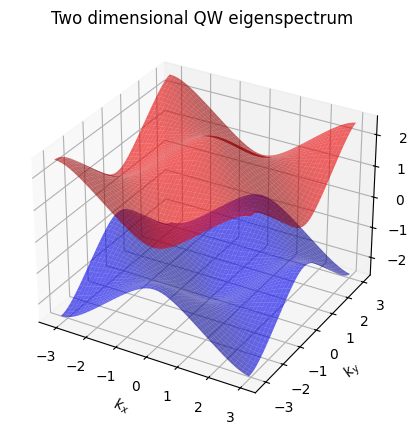

In [42]:
E_ = lambda k_x,k_y,thx,thy : np.arccos(np.cos(k_x+k_y)*np.cos(thx)*np.cos(thy) - np.cos(k_x-k_y)*np.sin(thx)*np.sin(thy))

thx = np.pi/1.5
thy = np.pi/8

dim = 50
k_x = 2*np.pi/dim * (np.arange(0,dim) - dim//2)
k_y = 2*np.pi/dim * (np.arange(0,dim) - dim//2)
k_x,k_y = np.meshgrid(k_x,k_y)

Spectrum = E_(k_x,k_y,thx,thy)
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(projection="3d")
ax.plot_surface(k_x,k_y,Spectrum,color = "red",alpha = 0.6)
ax.plot_surface(k_x,k_y,-Spectrum,color = "blue", alpha = 0.6)
ax.set_xlabel(r"$k_{x}$")
ax.set_ylabel(r"$k_{y}$")
ax.set_zlabel(r"$E_{\vec{k}}$")
ax.set_title("Two dimensional QW eigenspectrum")

In [45]:
dim_x = 40
dim_y = 40

x_coin_dict = {"th" : pi/2, "n" : [0,1,0]}
y_coin_dict = {"th" : pi/4,"n" : [0,1,0]}
init_state = {"a" : 1,"b" : -1j}

steps = 100

model = single_coin_two_dim_QW(dim_x,dim_y,x_coin_dict,y_coin_dict,**init_state)
data_ = model.evolve(steps)

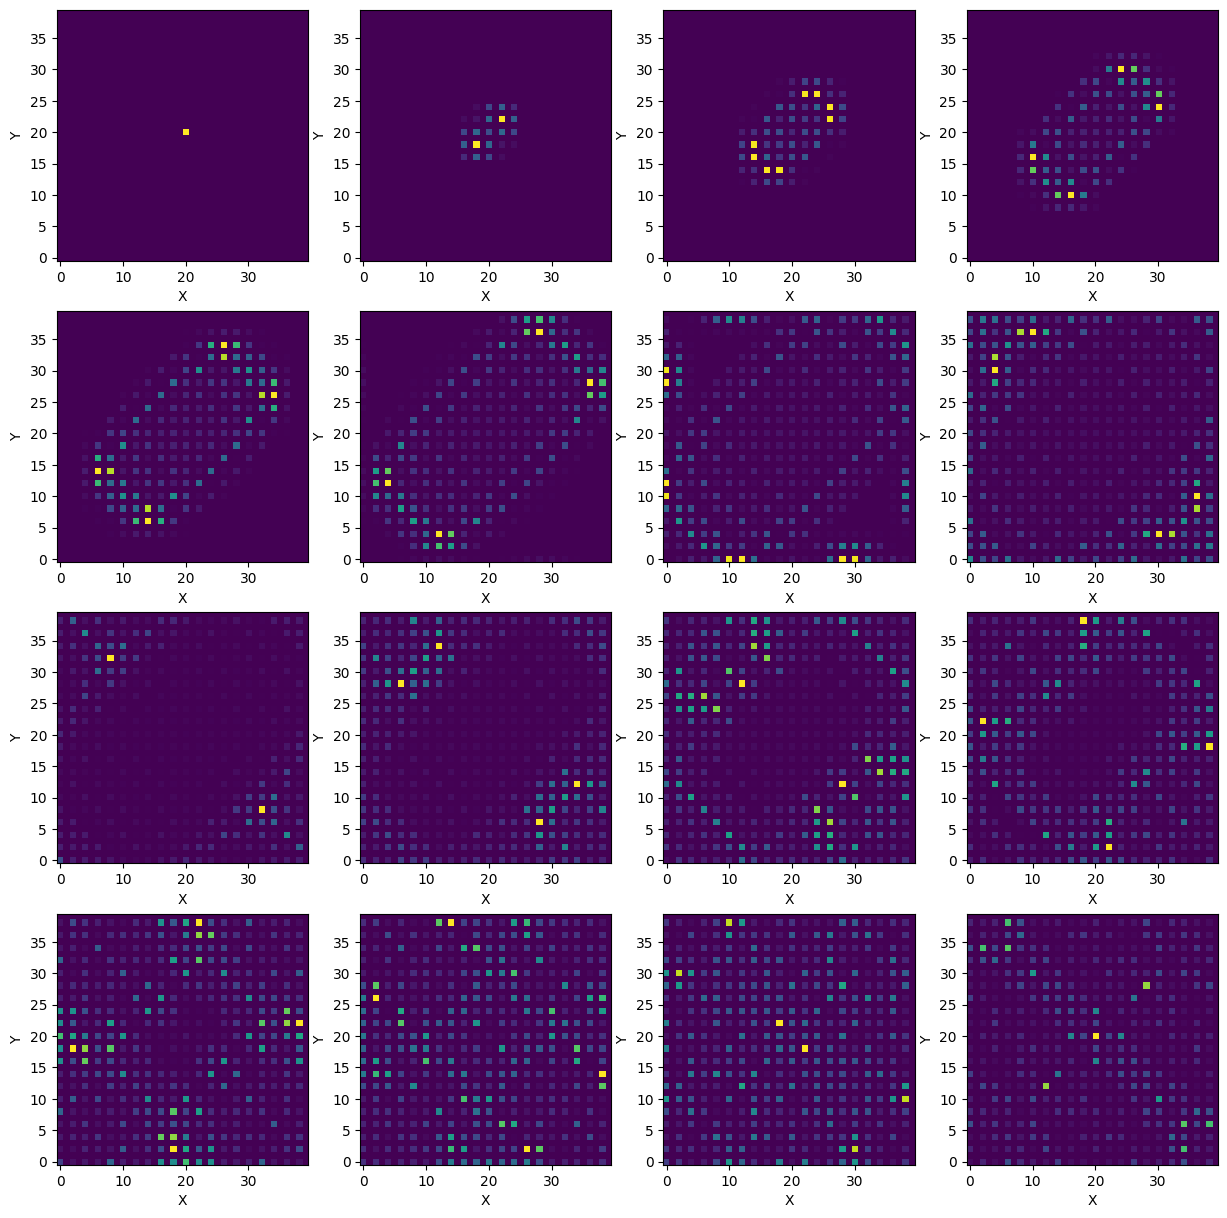

In [47]:
fig = plt.figure(figsize = (15,15))
for i in range(0,16):
    axs = fig.add_subplot(4,4,i+1)
    axs.imshow(data_[i*4],cmap='viridis',origin = "lower")
    axs.set_xlabel("X")
    axs.set_ylabel("Y")

<h1>Double coins, two-dimensional Quantum Walk</h1>

In [49]:
dim_x = 40
dim_y = 40

x_coin_dict = {
    "th" : pi/2,
    "n" : [0,1,0]
}
y_coin_dict = {
    "th" : pi/2,
    "n" : [0,1,0]
}
init_state = {
    "ax" : 1,
    "bx" : 0,
    "ay" : 1,
    "by" : 0
}

steps = 100

model = double_coin_two_dim_QW(dim_x,dim_y,x_coin_dict,y_coin_dict,**init_state)
data_ = model.Evolve(steps)

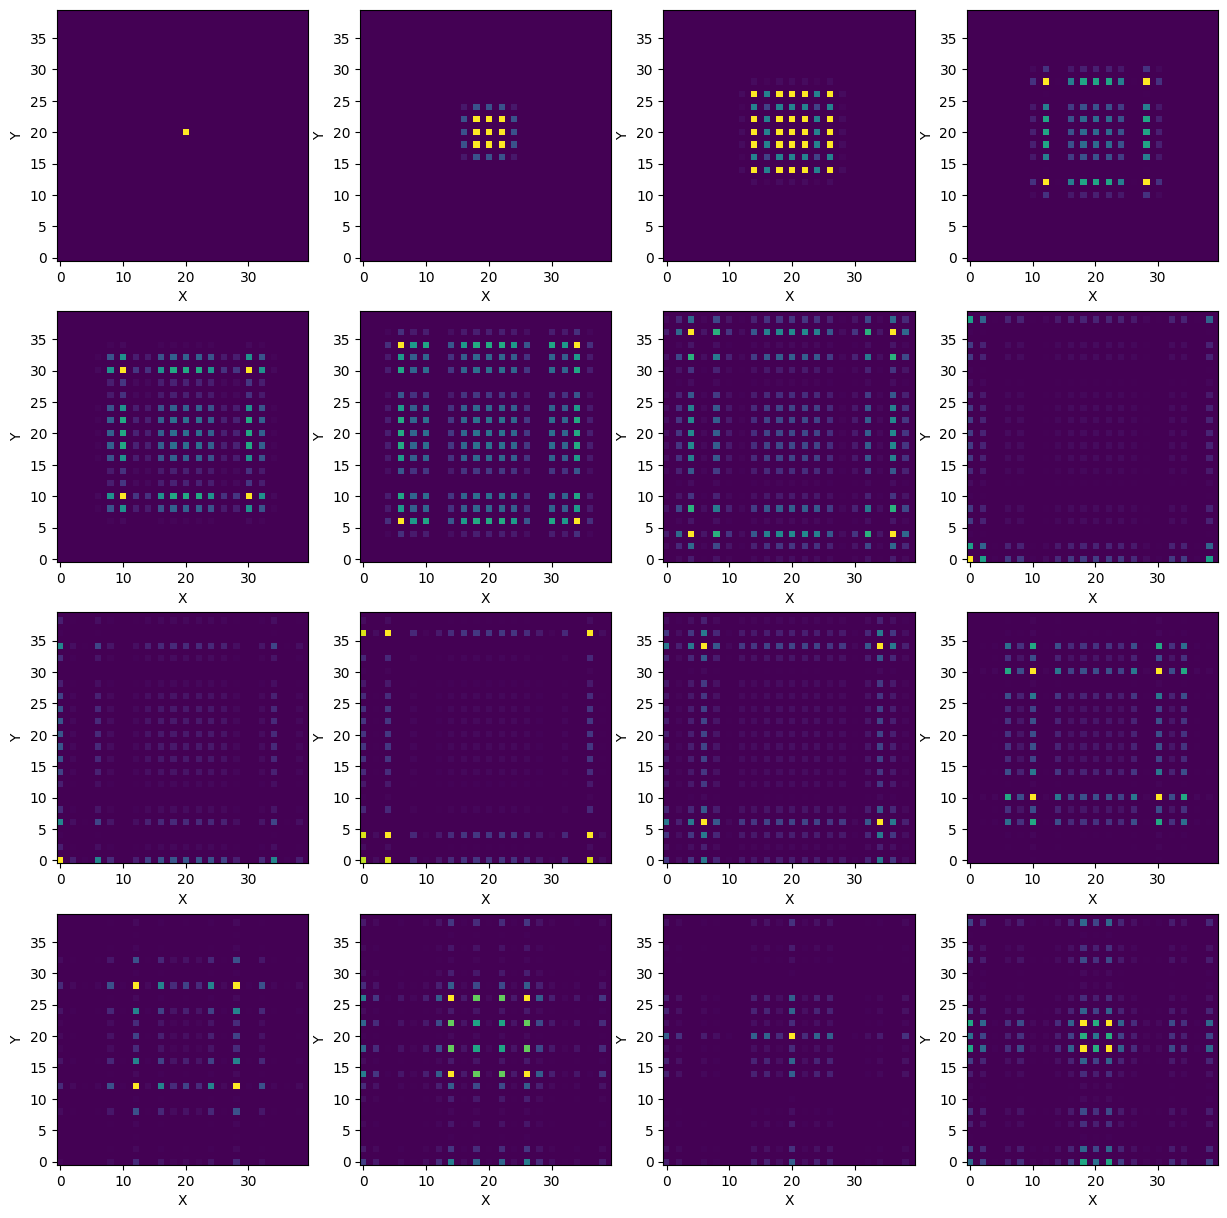

In [52]:
fig = plt.figure(figsize = (15,15))
for i in range(0,16):
    axs = fig.add_subplot(4,4,i+1)
    axs.imshow(data_[i*4],cmap='viridis',origin='lower')
    axs.set_xlabel("X")
    axs.set_ylabel("Y")